# Comparing the performance of different clustering algorithms on toy datasets on adding high dimensional gaussian noise

This experiment analyzes how different clustering algorithms perform on different datasets that are originally two dimensional when high dimensional gaussian noise is added to them. The experiment also shows how the performance of the clutstering algorithms in the above simulations is affected when the variance of the gaussian noise added is varied. This experiment is influenced by Scikitlearn's demo on clustering, 'Comparing different clustering algorithms on toy datasets'and is carried out with the aim of analyzing the behavior of different clustering algoithms when dealing with high dimensional data.


In [219]:
import time
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn import preprocessing

from sklearn.metrics import adjusted_rand_score

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 15})

## Generating toy datasets and defining the parameters for the clustering algorithms

The clustering algorithms whose performance is being evaluated are k-means clustering, agglomerative clustering, DBSCAN, GMM, spectral clustering, and affinity propagation. 

The 2D toy datasest are generated using make_blobs,make_classification, make_moons, and make_circles from sklearn.datasets. The generated datasets all of which have 500 samples with 2 features that belong to 2 classes are normalized before noise addition so as to make the variance 1, and centralize the data points around zero which enables easier parameter selection while clustering.

In [220]:
'''defining datasets'''
noiseDimensions=np.arange(0,110,10)
noise_levels=[0.1,1,10]
noiseRange=len(noiseDimensions)
trialNum=100
parameters={'samples':500,'features':2,'clusters':2,'eps': .3,'damping':0.9,'preference':-200}

initialBlobs = datasets.make_blobs(n_samples=parameters['samples'], 
                            centers=parameters['clusters'],
                            cluster_std=1,
                            random_state=8)

initialMoons = datasets.make_moons(n_samples=parameters['samples'], 
                            noise=0.06)
initialCircles = datasets.make_circles(n_samples=parameters['samples'], 
                                factor=0.5,
                                noise=0.06)
initialClassification = datasets.make_classification(n_samples=parameters['samples'], 
                                  n_features=parameters['features'],
                                  n_informative=parameters['features'],
                                  n_redundant=0,
                                  n_repeated=0,
                                  n_classes=parameters['clusters'],
                                  n_clusters_per_class=1,
                                  flip_y=0.1,
                                  random_state=8,
                                  shuffle=True)

'''Normalizing all the datasets for easier parameter selection'''
def standardize(inputData): # input should be the dataset
    temp = preprocessing.StandardScaler().fit_transform(inputData[0])
    standardizedInput = []
    standardizedInput.append(temp)
    standardizedInput.append(inputData[1])
    return standardizedInput

blobs = standardize(initialBlobs)
classification = standardize(initialClassification)
circles = standardize(initialCircles)
moons = standardize(initialMoons)

datasets = [blobs,classification,circles,moons]


names=['make_blobs','make_classification','make_circles','make_moons']

clustering_algorithms = [cluster.KMeans(n_clusters=parameters['clusters']),
                         cluster.AgglomerativeClustering(n_clusters=parameters['clusters'],linkage='ward'),
                         cluster.DBSCAN(eps=parameters['eps']),
                         mixture.GaussianMixture(n_components=parameters['clusters'],covariance_type='full'),
                         cluster.SpectralClustering(n_clusters=parameters['clusters'],eigen_solver='arpack',affinity='nearest_neighbors'),
                         cluster.AffinityPropagation(damping=parameters['damping'],preference=parameters['preference'])]
clustering_names=['K-means Clustering','Agglomerative Clustering','DBSCAN','GMM','Spectral Clustering','Affinity Propagation']

The plots below enable us to view the true labels of the original 2D data after standardization.

Text(-0.022, 0.5, 'X2')

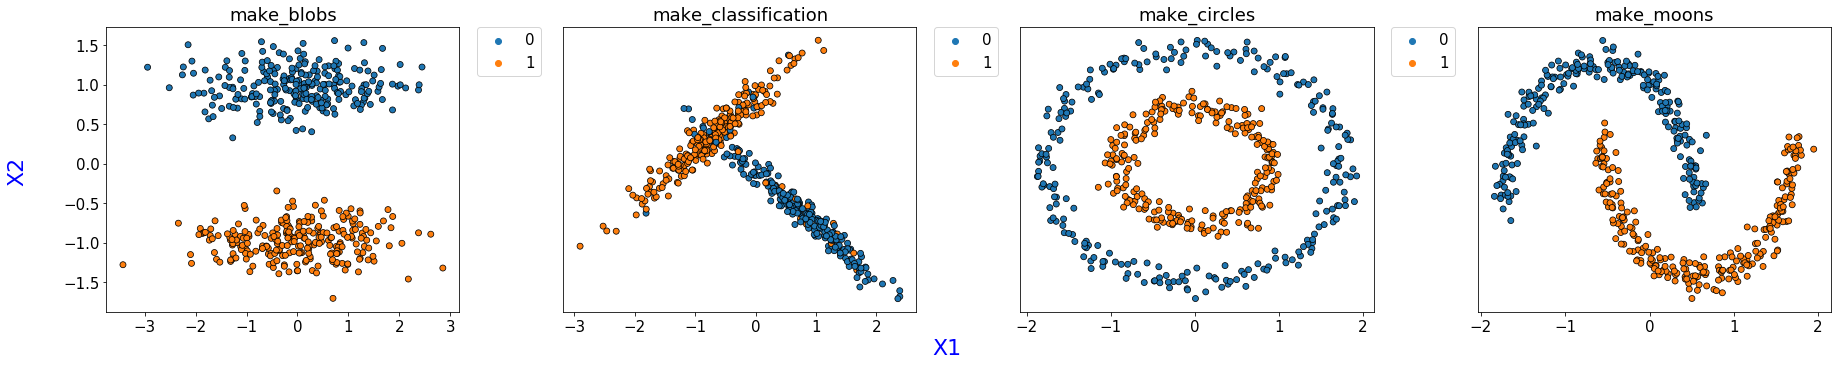

In [284]:
'''Plotting the data'''
f, axes = plt.subplots(1, 4, figsize=(25, 5), sharex=True)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    plt.subplot(1,4,index+1)
    ax=sns.scatterplot(dataset[0][:,0],dataset[0][:,1],hue=dataset[1],edgecolor='black')
    plt.title(name)
    plt.tight_layout()
    if (index+1!=1):
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if (index+1!=4):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        ax.legend_.remove()
    plt.tight_layout()
f.text(0.5, -0.012, 'X1', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'X2', va='center', rotation='vertical',color='b',fontsize=22)


## Adding noise and computing the accuracy
In each simulation different clustering algorithms are performed after gaussian noise of dimension n is added to the generated datasets where n=0,10,...,100. The performance of the clustering algorithms is measured using adjusted rand index (ARI) as the metric. 

The above experiment is carried out by changing the variance of the added noise to analyze also the effect of increasing variance in the above simulations. A noise with standard deviation of 0.1 is regarded as having low variance, 1 as having moderate variance, and 10 as having high variance in this context. The gaussian noise added is always centered around zero. There are 100 trials for this experiment, and the mean and variance resulting from these 100 trails are used in plotting the results so as to minimize random effects in the experiment.

In [222]:
'''Adding high dimensional noise'''
def addNoise(x,noiseDim,noise_std,samples=samples,noise_mean=0):
    tempNoise=np.random.normal(noise_mean,noise_std,[samples,noiseDim])
    data=np.concatenate((x,tempNoise),axis=1)
    return data

In [223]:
def accuracy(algorithm,dataX,dataY):
    cluster=algorithm.fit(dataX)
    label=cluster.labels_
    ARI=adjusted_rand_score(label,dataY)
    return ARI

def accuracyGaussian(algorithm,dataX,dataY):
    cluster=algorithm.fit(dataX)
    label=cluster.predict(dataX)
    ARI=adjusted_rand_score(label,dataY)
    return ARI

def toPlot(noiseStd):
    ARI=np.zeros((len(datasets),len(clustering_algorithms),trialNum,noiseRange))
    allTrialARI=np.zeros((len(datasets),len(clustering_algorithms),noiseRange*trialNum)) # to create dataframe
    theNoiseDim=np.zeros((len(datasets),len(clustering_algorithms),noiseRange*trialNum))
    allARI=[[],[],[],[]]
    event=[[],[],[],[]]
    allNoise=[[],[],[],[]]
    for index,dataset in enumerate(datasets):
        for ind,algorithm in enumerate(clustering_algorithms):
            for trial in range(trialNum):
                for noiseIndex,noise in enumerate(noiseDimensions):
                    newX=addNoise(dataset[0],noise,noiseStd)
                    if ind==3:
                        ARI[index][ind][trial][noiseIndex]=accuracyGaussian(algorithm,newX,dataset[1])
                    else:
                        ARI[index][ind][trial][noiseIndex]=accuracy(algorithm,newX,dataset[1])
                    allTrialARI[index][ind][noiseIndex+trial*noiseRange]=ARI[index][ind][trial][noiseIndex]
                    theNoiseDim[index][ind][(noiseIndex)+trial*noiseRange]=noise
                    #to create a combined plot
                    allARI[index].append(ARI[index][ind][trial][noiseIndex])
                    event[index].append(clustering_names[ind])
                    allNoise[index].append(noise)
                    
    return allNoise,event,allARI,theNoiseDim,allTrialARI

allNoise_1,event_1,allARI_1,theNoiseDim_1,allTrialARI_1=toPlot(0.1) # arrays corresponding to noise_std=0.1
allNoise_2,event_2,allARI_2,theNoiseDim_2,allTrialARI_2=toPlot(1) # arrays corresponding to noise_std=1
allNoise_3,event_3,allARI_3,theNoiseDim_3,allTrialARI_3=toPlot(10) # arrays corresponding to noise_std=10

Plotting the number of noise dimensions against ARI enables a better visualization of change in the performance of each clustering algorithm with the number of noise dimensions for different datasets. The three plots that follow give a better intuition on how the whole scenario changes when dealing with noise of three different variances.

In [224]:
'''plotting ARI vs number of noise dimensions'''
def Plot(z,dimensions,RandIndex,dataset,algo,x=len(datasets),y=len(clustering_algorithms)): # dimensions is theNoiseDim[w][r] and RandIndex is allTrialARI[w][r], title is the name
    plt.subplot(x,y,z)
    data={'Number of Noise Dimensions':dimensions,'ARI':RandIndex}
    sns.lineplot(x='Number of Noise Dimensions',y='ARI',data=data)
    if(z%len(clustering_algorithms)==1):
        plt.ylabel( dataset )
    else:
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if(z<=(len(datasets)-1)*len(clustering_algorithms)):
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    if(z<=len(clustering_algorithms)):
        plt.title(algo)
    plt.ylim(-0.1,1.1)
    plt.tight_layout()
    return data


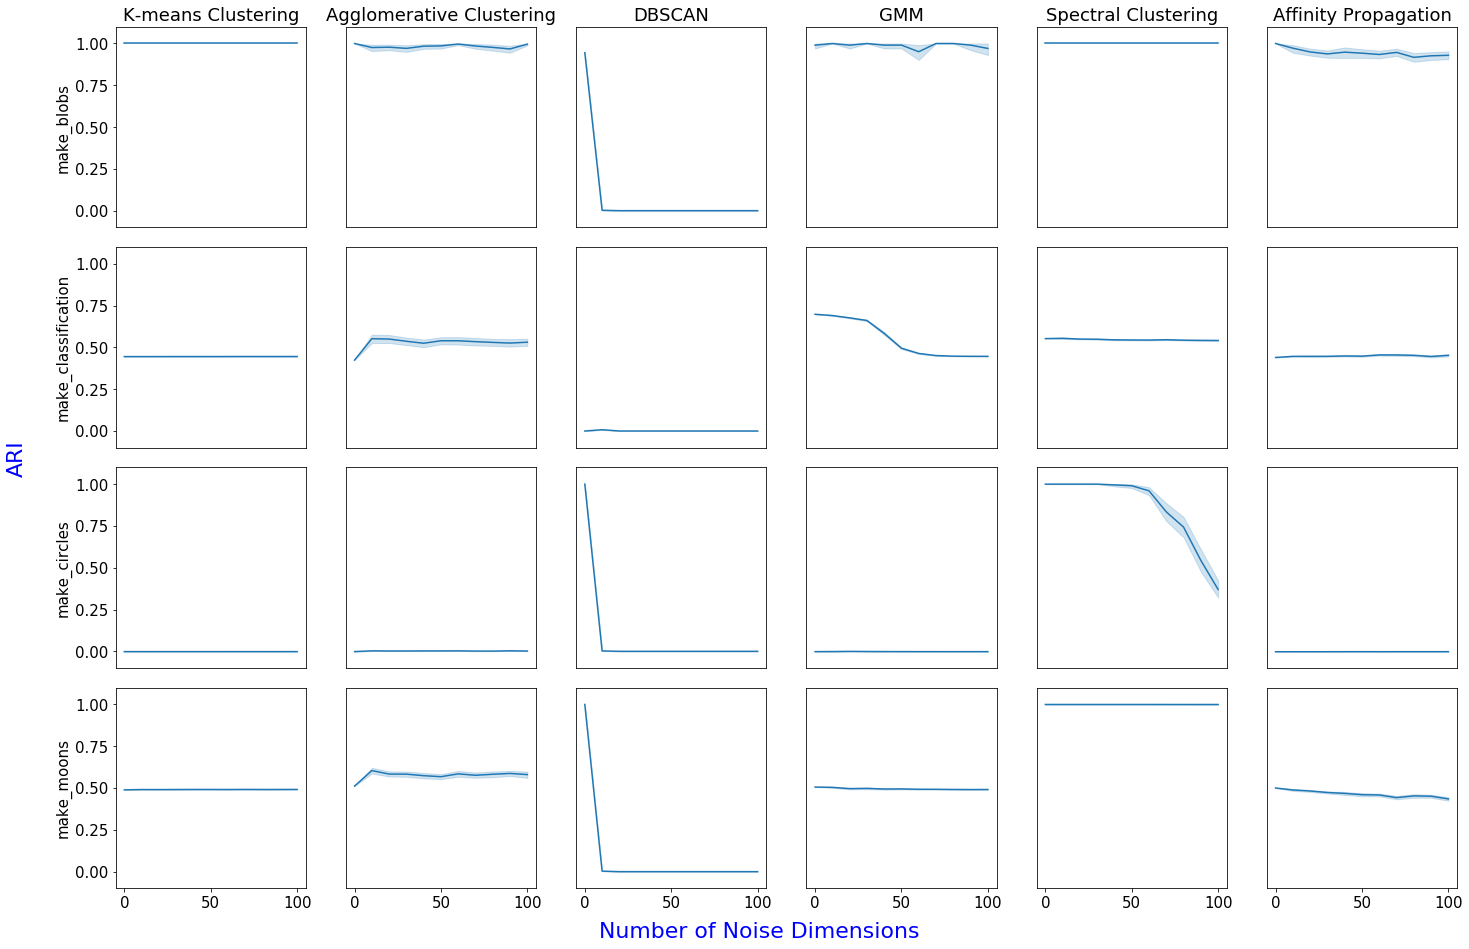

In [225]:
# plot when noise_std=0.1
f,axes=plt.subplots(len(datasets),len(clustering_algorithms),figsize=(20, 13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    for ind,(algorithm,algoName) in enumerate(zip(clustering_algorithms,clustering_names)):
        Plot(index*len(clustering_algorithms)+1+ind,theNoiseDim_1[index][ind],allTrialARI_1[index][ind],name,algoName)

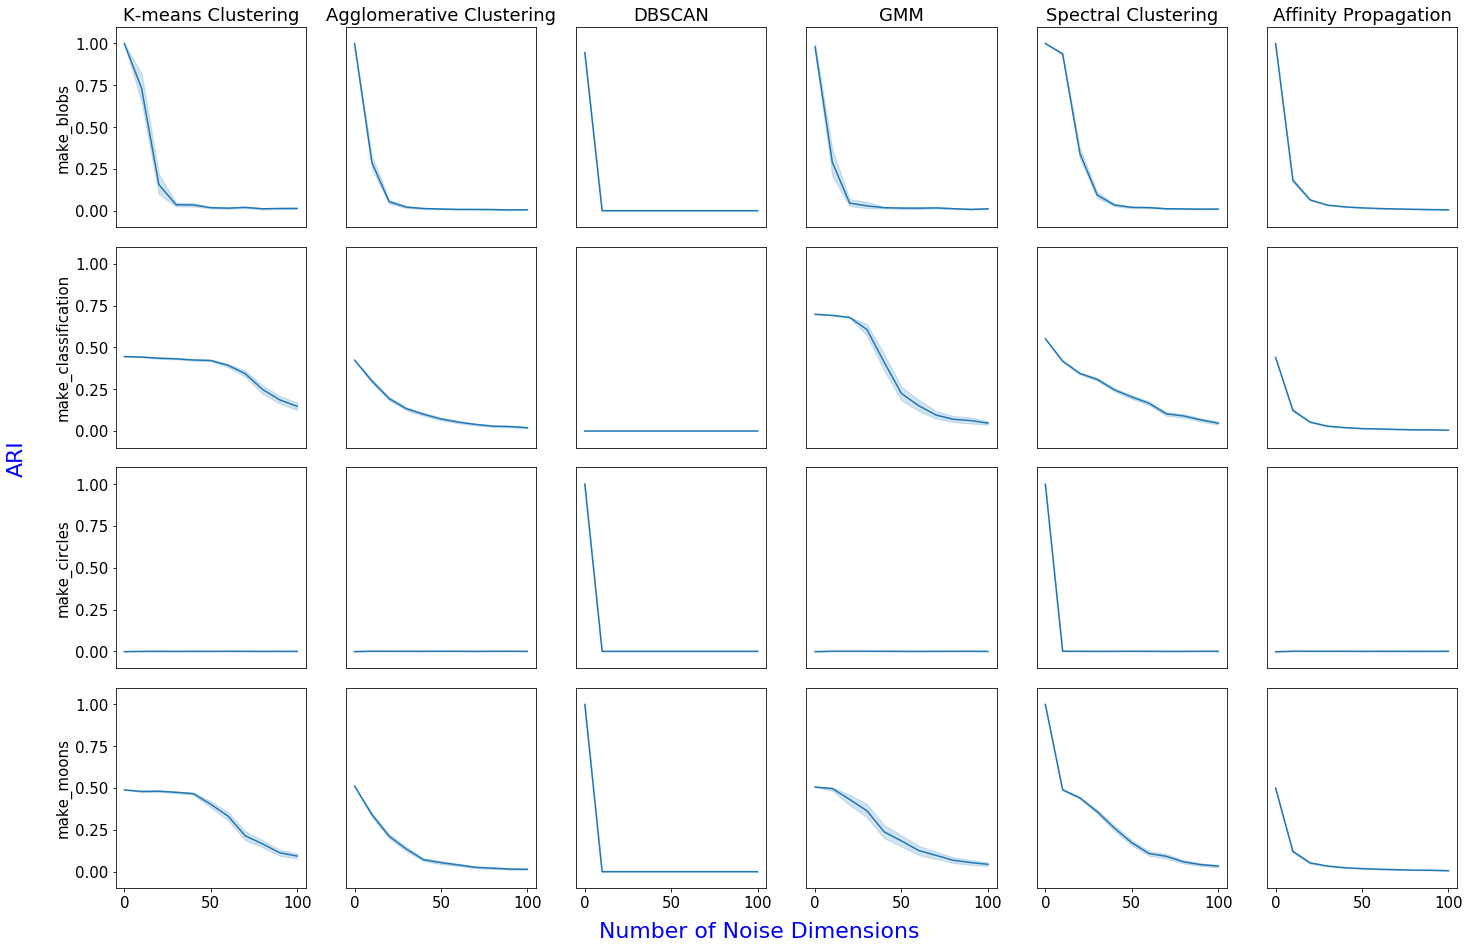

In [226]:
# plot when noise_std=1
f,axes=plt.subplots(len(datasets),len(clustering_algorithms),figsize=(20, 13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    for ind,(algorithm,algoName) in enumerate(zip(clustering_algorithms,clustering_names)):
        Plot(index*len(clustering_algorithms)+1+ind,theNoiseDim_2[index][ind],allTrialARI_2[index][ind],name,algoName)

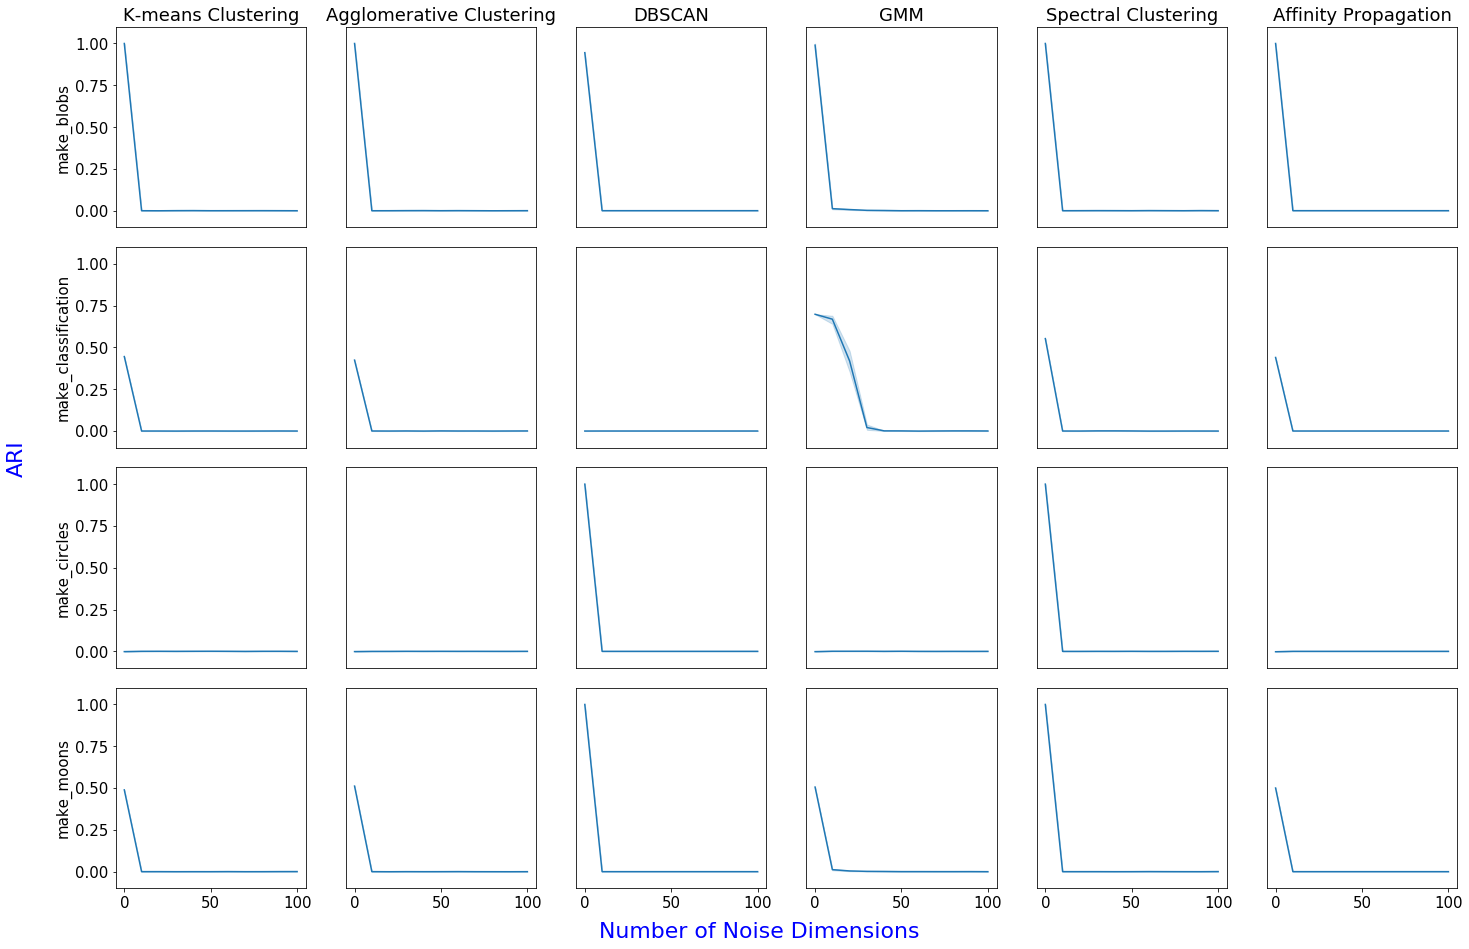

In [227]:
# plot when noise_std=10
f,axes=plt.subplots(len(datasets),len(clustering_algorithms),figsize=(20, 13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,(dataset,name) in enumerate(zip(datasets,names)):
    for ind,(algorithm,algoName) in enumerate(zip(clustering_algorithms,clustering_names)):
        Plot(index*len(clustering_algorithms)+1+ind,theNoiseDim_3[index][ind],allTrialARI_3[index][ind],name,algoName)

## Result interpretation

When the noise standard deviation is low (noise_std=0.1), spectral clustering seems to give the best performance. Spectral clustering has a near perfect ARI when applied to make_blobs and make_moons datasets and this doesn't seem to be affected on increasing the noise dimension from 0 to 100. Also, it shows better performance compared to other clustering algoithms in the case of make_classification. To add, this is the only algorithm that does a good job in clustering in the case of make_circles other than DBSCAN. Here while spectral clustering has a near-perfect ARI on the addition of upto 50 noise dimensions, the accuracy of DBSCAN drops to zero soon after noise of any dimension is added. The performances of agglomerative clustering, affinity propagation, and k-means clustering algorithms don't seem to change on increasing the noise dimensions but at the same time give out the worst performance with ARI nearly equal to zero in the case of make_circles. Although GMM is similar to these thre algorithms in performance, it is affected more by the addition of increasing noise dimensions. 


DBSCAN performs worst consistently on applying to make_classification. In other datasets although it has a near perfect ARI when no noise dimension is added, the performance plummets down and reaches close to zero as soon as noise of any dimension is added. In summary, spectral clustering does a better job compared to other algorithms under consideration in terms of performance and susceptibility to increasing addition of noise dimensions.

When the noise standard deviation is moderate (noise_std=1), spectral clustering again performs better compared to others and is comparatively less susceptible to increasing noise dimesions. All algorithms seem to fail in clustering when noise of any dimension with high variance (noise_std=10) is added.

To summarize, spectral clustering wins when noise with moderate or low variance is added.

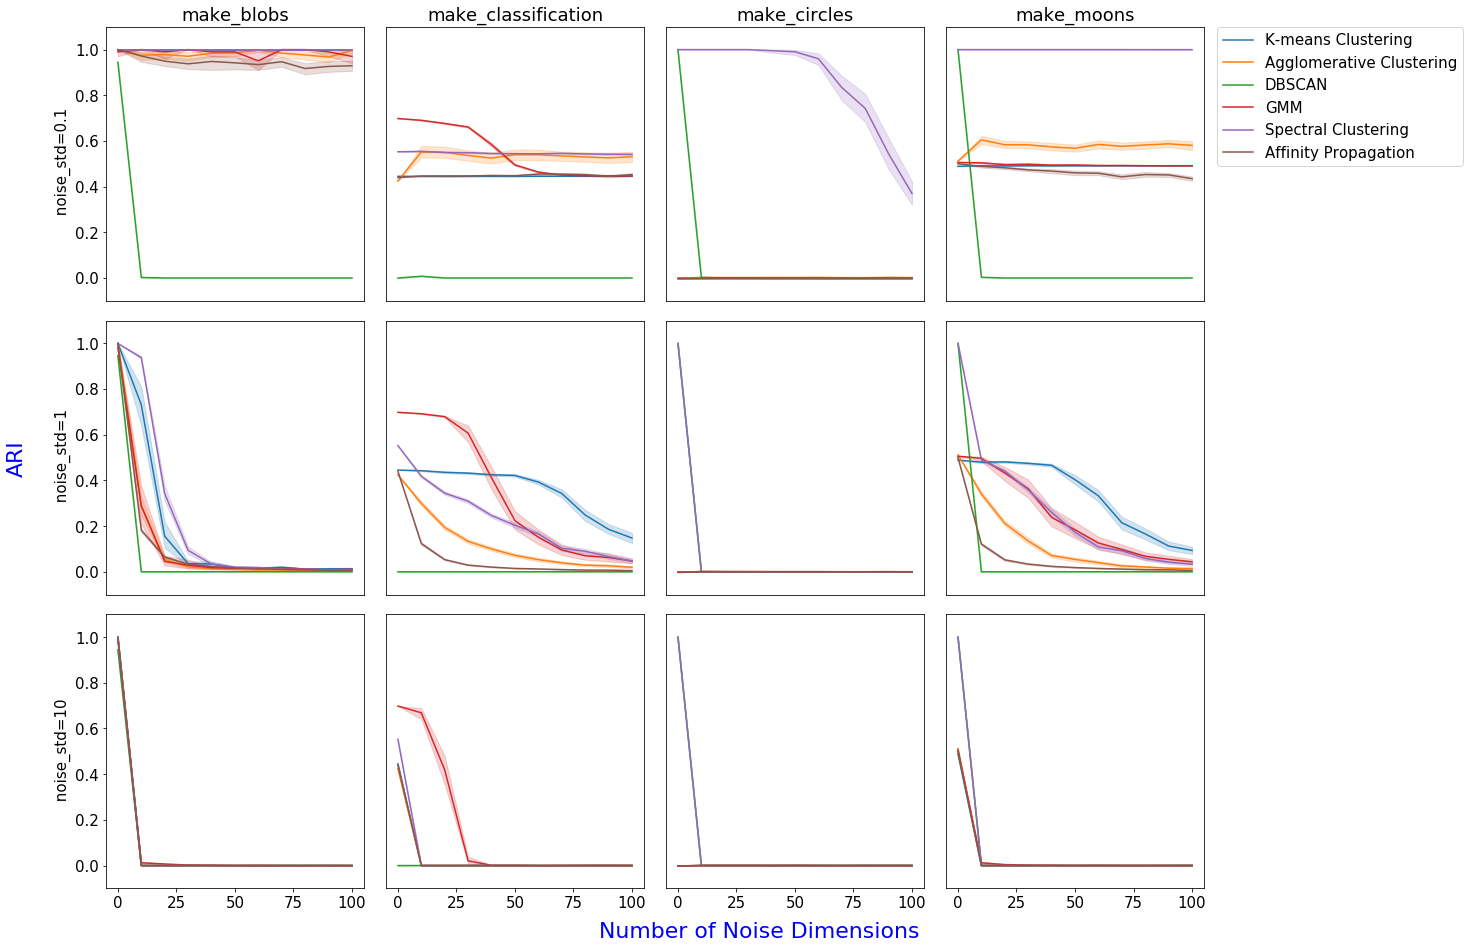

In [246]:
allARI=[allARI_1,allARI_2,allARI_3]
allNoise=[allNoise_1,allNoise_2,allNoise_3]
event=event_1 # event_1, event_2, and event_3 are all the same arrays
def plotAll(z,dimension,RandIndex,dataset,noise_level,event=event[0],x=len(noise_levels),y=len(datasets)):
    plt.subplot(x,y,z)
    data={'Number of Noise Dimensions':dimension,'ARI':RandIndex,'Event':event}
    ax=sns.lineplot(x='Number of Noise Dimensions',y='ARI',hue='Event',data=data)
    if (z%len(datasets)==1):
        plt.ylabel(' noise_std='+ str(noise_level))
    else:
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if(z<=(len(noise_levels)-1)*len(datasets)):
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    if(z<=len(datasets)):
        plt.title(dataset)    
    plt.tight_layout()
    if(z!=len(datasets)):
        ax.legend_remove()
    if(z==len(datasets)):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-0.1,1.1)
    return data

f,axes=plt.subplots(len(noise_levels),len(datasets),figsize=(20,13),sharex=True,sharey=True)
f.text(0.5, -0.012, 'Number of Noise Dimensions', ha='center',color='b',fontsize=22)
f.text(-0.022, 0.5, 'ARI', va='center', rotation='vertical',color='b',fontsize=22)
for index,noise_level in enumerate(noise_levels):
    for ind,(dataset,name) in enumerate(zip(datasets,names)):
        plotAll(index*len(datasets)+1+ind,allNoise[index][ind],allARI[index][ind],name,noise_level)